# Negatively Correlated Channels

_Author:_ Karl-Ludwig Besser, Technische Universität Braunschweig, Germany

This notebook is part of the paper "Copula-Based Bounds for Multi-User Communications - Part I: Average Performance" ([doi:XXX](https://doi.org/XXX)).  
If you use any of this work, please cite the above paper.

> If you are not familiar with Jupyter notebooks: The easiest way to use this notebook interactively, is to hit `Kernel --> Restart & Run All` in the menu. The will execute all cells and enable the interactive elements of the plots.  
> Alternatively, you can execute the cells one by one using Shift+Return

In [1]:
import numpy as np
from scipy import stats
from scipy import optimize
from scipy import special
%matplotlib notebook
import matplotlib.pyplot as plt
from ipywidgets import interact

## Setup

We have a transmitter (Tx) with a single antenna at height $h_{\text{Tx}}$. Next, we have two receive antennas (Rx) which are placed on top of each other at heights $h_1$ and $h_2 = h_1 + \Delta h$. The receivers are placed at a distance $d$ from the transmitted.

Both receive a LOS signal after the delay $\tau_{0,i}$.
Due to a reflection of the ground, there also is a NLOS component, which is received at Rx $i$ after the delay $\tau_{1,i}$. 

The signal at receiver $i$ is given as
$$r_{i}(t) = A_1 \cos\left(\omega(t-\tau_{0,i})\right) + A_{2}\cos\left(\omega(t-\tau_{1,i})\right).$$
The squared envelope is given as
$$X_{i} = \left(A_1 \sin\left(\omega \tau_{0,1}\right) + A_2 \sin\left(\omega \tau_{1,i}\right)\right)^2 + \left(A_1 \cos\left(\omega \tau_{0,1}\right) + A_2 \cos\left(\omega \tau_{1,i}\right)\right)^2.$$

In [2]:
def rec_signal(t, tau, t0=1., a1=1, a2=.5, omega=1):
    return a1*np.cos(omega*(t-t0)) + a2*np.cos(omega*(t-tau))

In [3]:
def squared_envelope(tau, t0=0, a1=1, a2=.5, omega=1):
    _part1 = (a1*np.sin(omega*t0) + a2*np.sin(omega*tau))**2
    _part2 = (a1*np.cos(omega*t0) + a2*np.cos(omega*tau))**2
    return _part1 + _part2

## Geometry

The values of $\tau_{0,i}$ and $\tau_{1,i}$ are determined by the geometry, where we assume that it is proportional to the distance, i.e., assuming a constant propagation speed.

The distances can easily be calculated using some basic trigonometry.
Below, you can find a plot of the geometric layout.

In [4]:
def tau0(height, h_tx=10., dist=4, c=1):
    return c*np.sqrt(dist**2 + (h_tx-height)**2)

def tau1(height, h_tx=10., dist=4, c=1):
    dist_tx_r = np.sqrt(h_tx**2 + (dist*h_tx/(h_tx+height))**2)
    dist_r_rx = np.sqrt(height**2 + (dist*height/(h_tx+height))**2)
    return c * (dist_r_rx + dist_tx_r)

In [5]:
def single_receiver(distance=20):
    h_tx = 10.
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Distance $d$")
    ax1.set_ylabel("Height $h$")
    ax1.hlines(0, 0, distance, lw=2)
    ax1.plot([0], [h_tx], 'o--')
    rx1 = ax1.plot([distance], [0], 'o', color='r', label="Rx1")[0]
    rx2 = ax1.plot([distance], [0], 'o', color='b', label="Rx2")[0]
    d01 = ax1.plot([0, distance], [h_tx, 0], '-', color='r')[0]
    d02 = ax1.plot([0, distance], [h_tx, 0], '-', color='b')[0]
    d11 = ax1.plot([0, distance/2, distance], [h_tx, 0, 0], '--', color='r')[0]
    d12 = ax1.plot([0, distance/2, distance], [h_tx, 0, 0], '--', color='b')[0]
    ax1.legend()
    def update_plot(h_1=1, delta_h=1):
        #ax1.clear()
        h_2 = h_1 + delta_h
        l_1 = distance*h_tx/(h_1+h_tx)
        l_2 = distance*h_tx/(h_2+h_tx)
        rx1.set_ydata(h_1)
        d01.set_ydata([h_tx, h_1])
        d02.set_ydata([h_tx, h_2])
        d11.set_data([0, l_1, distance], [h_tx, 0, h_1])
        d12.set_data([0, l_2, distance], [h_tx, 0, h_2])
        rx2.set_ydata(h_2)
        print("Rx1:\ttau0 = {:.3f}\ttau1 = {:.3f}".format(tau0(h_1, h_tx=h_tx, dist=distance),
                                                      tau1(h_1, h_tx=h_tx, dist=distance)))
        print("Rx2:\ttau0 = {:.3f}\ttau1 = {:.3f}".format(tau0(h_2, h_tx=h_tx, dist=distance),
                                                      tau1(h_2, h_tx=h_tx, dist=distance)))
    interact(update_plot, h_1=(1, 5, .2), delta_h=(1, 3, .1))

<IPython.core.display.Javascript object>


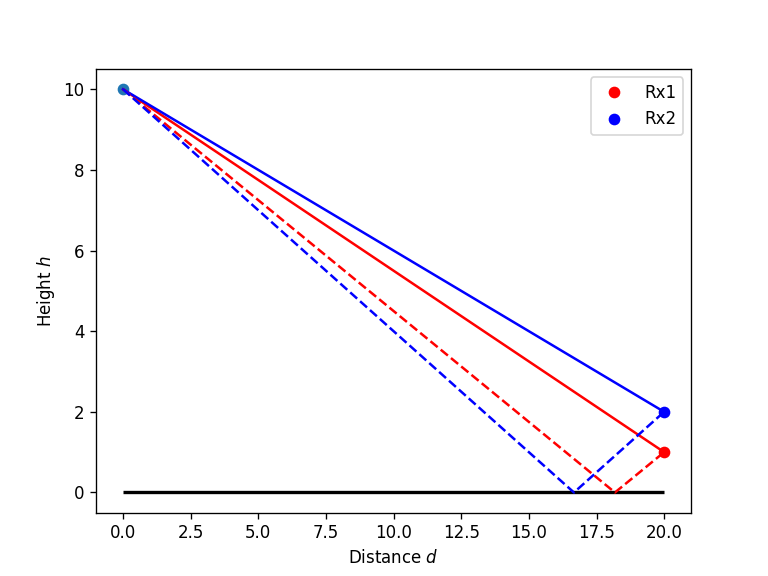

interactive(children=(FloatSlider(value=1.0, description='h_1', max=5.0, min=1.0, step=0.2), FloatSlider(value…

In [6]:
single_receiver()

## Received Signal

In [7]:
def plot_rec_signal(distance=20., h_tx=10.):
    fig, ax1 = plt.subplots()
    t = np.linspace(0, 15, 100)
    plots_signal = {1: ax1.plot(t, np.zeros(len(t)), label="Receiver 1")[0],
                    2: ax1.plot(t, np.zeros(len(t)), label="Receiver 2")[0],
                   }
    plots_envelope = {1: ax1.plot(t, np.zeros(len(t)), label="Envelope 1")[0],
                      2: ax1.plot(t, np.zeros(len(t)), label="Envelope 2")[0],
                     }
    ax1.set_xlim([0, 15])
    ax1.set_ylim([-2, 2])
    ax1.set_xlabel("Time $t$")
    ax1.set_ylabel("Received Signal $x_{r}(t)$")
    plt.legend()
    def update_plot(h_1=1, delta_h=1):
        for rec, plot in plots_signal.items():
            if rec == 1:
                _h = h_1
            else:
                _h = h_1 + delta_h
            t0 = tau0(_h, h_tx=h_tx, dist=distance)
            t1 = tau1(_h, h_tx=h_tx, dist=distance)
            plot.set_ydata(rec_signal(t, t1, t0=t0))
            plots_envelope[rec].set_ydata(np.sqrt(squared_envelope(t1, t0=t0)))
    interact(update_plot, h_1=(1, 5, .2), delta_h=(1, 5, .1))

<IPython.core.display.Javascript object>


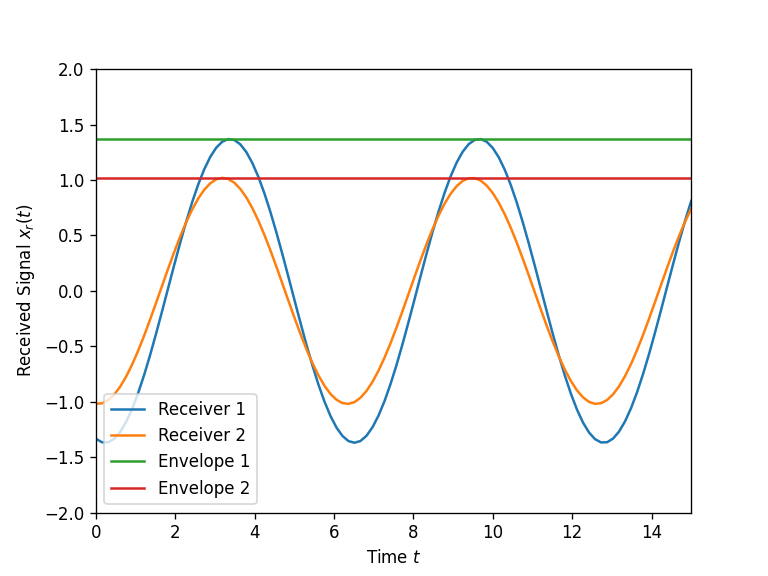

interactive(children=(FloatSlider(value=1.0, description='h_1', max=5.0, min=1.0, step=0.2), FloatSlider(value…

In [8]:
plot_rec_signal()

## Receive Envelopes

In [9]:
from probability_bounds import export_results

def envelopes_over_distance(h_tx=10., export=False):
    fig, ax1 = plt.subplots()
    ax1.set_xlabel("Distance $d$")
    ax1.set_ylabel("Squared Envelopes $X_i$")
    distances = np.linspace(1, 50, 100)
    results = {"distance": distances}
    plot1 = ax1.plot(distances, np.zeros(len(distances)))[0]
    plot2 = ax1.plot(distances, np.zeros(len(distances)))[0]
    ax1.set_xlim([min(distances), max(distances)])
    ax1.set_ylim([0, 3])
    def update_plot(h_1=1, delta_h=1):
        h_2 = h_1 + delta_h
        tau0_1 = tau0(h_1, h_tx=h_tx, dist=distances)
        tau1_1 = tau1(h_1, h_tx=h_tx, dist=distances)
        tau0_2 = tau0(h_2, h_tx=h_tx, dist=distances)
        tau1_2 = tau1(h_2, h_tx=h_tx, dist=distances)
        e1 = squared_envelope(tau1_1, t0=tau0_1)
        e2 = squared_envelope(tau1_2, t0=tau0_2)
        print(np.corrcoef(e1, e2))
        plot1.set_ydata(e1)
        plot2.set_ydata(e2)
        if export:
            results["x1"] = e1
            results["x2"] = e2
            filename = "rec_evelopes-htx{}-h1{}-dh{}.dat".format(h_tx, h_1, delta_h)
            export_results(results, filename)
    interact(update_plot, h_1=(1, 10, .2), delta_h=(1, 5, .1))

<IPython.core.display.Javascript object>


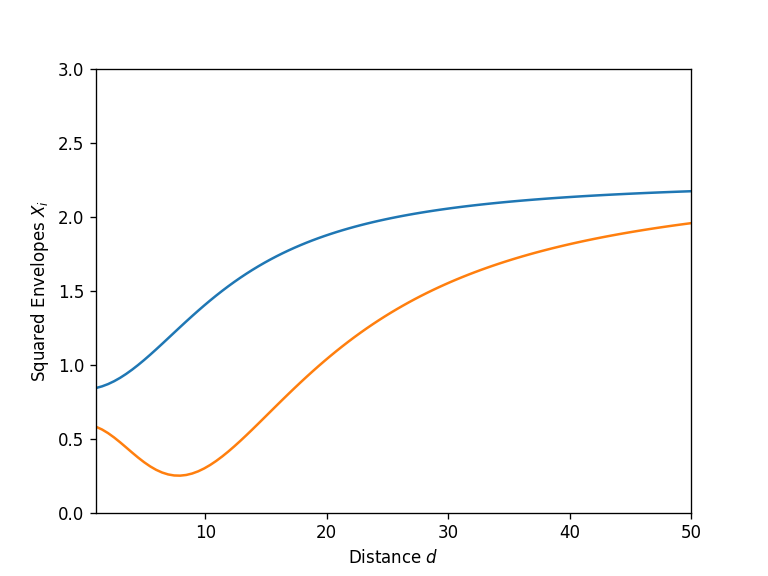

interactive(children=(FloatSlider(value=1.0, description='h_1', max=10.0, min=1.0, step=0.2), FloatSlider(valu…

In [10]:
envelopes_over_distance()

# Simulation

Next, we will run a short simulation where we place the transmitter in the center $(0, 0)$ at height $h_{\text{Tx}}=10$. We then randomly place receivers in the box $[-20, 20]^2$. The height of the first receive antenna is $h_1=1$. The height of the second antenna $h_2=h_1+\Delta h$ can be varied.  
Different heights of the second antenna create different correlation coefficients.

In [11]:
def run_simulation(N=1000, height_tx=10., height_1=1):
    fig, ax1 = plt.subplots()
    ax1.set_xlim([-20, 20])
    ax1.set_ylim([-20, 20])
    ax1.plot([0], [0], 'ro', label="Tx")
    pos = stats.uniform(-20, 40).rvs(size=(N, 2))
    ax1.scatter(pos[:, 0], pos[:, 1], label="Rx")
    ax1.legend()
    #height_1 = 2*np.random.rand(N) + 1  # use this to also randomly select the height of the first antenna
    distances = np.linalg.norm(pos, axis=1)
    tau0_1 = tau0(height_1, h_tx=height_tx, dist=distances)
    tau1_1 = tau1(height_1, h_tx=height_tx, dist=distances)
    e1 = squared_envelope(tau1_1, t0=tau0_1)
    def update_plot(delta_h=1):
        height_2 = delta_h + height_1
        tau0_2 = tau0(height_2, h_tx=height_tx, dist=distances)
        tau1_2 = tau1(height_2, h_tx=height_tx, dist=distances)
        e2 = squared_envelope(tau1_2, t0=tau0_2)
        print(np.corrcoef(e1, e2))
    interact(update_plot, delta_h=(.5, 4, .1))

<IPython.core.display.Javascript object>


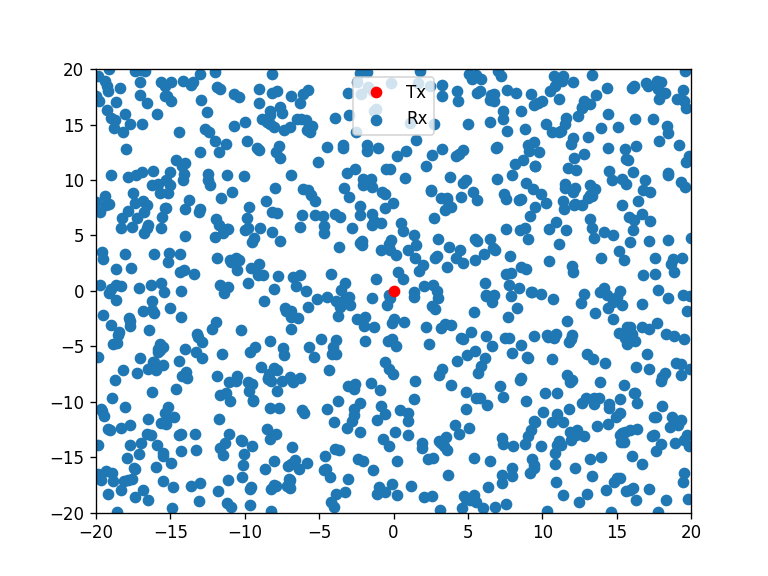

interactive(children=(FloatSlider(value=1.0, description='delta_h', max=4.0, min=0.5), Output()), _dom_classes…

In [12]:
run_simulation()